In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import Xception, EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, classification_report
from scipy.stats import ttest_ind
import cv2

# Vision Transformer (ViT) implementation based on the original ViT architecture: Dosovitskiy et al. (2020). 'An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale' https://arxiv.org/abs/2010.11929
# Simplified using Keras layers and inspired by Keras official example: https://keras.io/examples/vision/image_classification_with_vision_transformer/ + Community tutorials and open-source GitHub implementations

# CNN transfer learning setup using pretrained models from TensorFlow Keras Applications:
# Xception: Chollet, F. (2017). 'Xception: Deep Learning with Depthwise Separable Convolutions.' https://arxiv.org/abs/1610.02357
# EfficientNetB0: Tan, M. & Le, Q. (2019). 'EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks.' https://arxiv.org/abs/1905.11946

# Data path: set to google drive
DATASET_PATH = "/content/drive/MyDrive/Dataset"
TEST_PATH = "/content/drive/MyDrive/test-task1"
CHECKPOINT_EXT = ".keras"

# LOADING TRAINING DATA

print("Loading training data...")
X_all, y_all, gan_labels = [], [], []
for folder in os.listdir(DATASET_PATH):
    if folder.startswith('0-') or folder.startswith('1-'): #the folder Dataset has 7 folders. 2 starting with 0-, containing real images and 5 starting with 1-, containing deepfake images
        label = int(folder.split('-')[0])
        gan_type = folder.split('-')[1]
        folder_path = os.path.join(DATASET_PATH, folder)
        for img_name in os.listdir(folder_path):
            if img_name.lower().endswith(('.jpg', '.jpeg', '.png')): #since the different folders contain different types of extentions
                img_path = os.path.join(folder_path, img_name)
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256)) # Deep learning models require fixed-size inputs. Resizing ensures that every image fed into the model has the same dimensions.
                img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0 # Normalizes pixel values to [0,1] for better model training behavior.
                X_all.append(img_array)
                y_all.append(label)
                gan_labels.append(gan_type if label == 1 else 'REAL') #Store GAN type for later analysis

X_all = np.array(X_all)
y_all = np.array(y_all)
gan_labels = np.array(gan_labels)
print(f"Total images: {len(X_all)}")
print(f"Total images: {len(X_all)}")
print(f"Class counts: Real={sum(y_all==0)}, Fake={sum(y_all==1)}") #To check if images and labels have loaded correctly

# LOADING TEST SET

print("\nLoading test data...")
test_labels = pd.read_csv(
    os.path.join(TEST_PATH, "label-task1.txt"), sep=' ', header=None, names=['filename', 'label'] # File label-task1.txt contains the labels of the test set
)

X_test, y_test = [], []
for _, row in test_labels.iterrows():
    img_path = os.path.join(TEST_PATH, row['filename'])
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256)) # Again resizing
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0 # Again Normalizing
    X_test.append(img_array)
    y_test.append(row['label'])

X_test = np.array(X_test)
y_test = np.array(y_test)
print(f"Test set size: {len(X_test)}")


Loading training data...
Total images: 15000
Total images: 15000
Class counts: Real=10000, Fake=5000

Loading test data...
Test set size: 7000



 Training Xception

Fold 1
Training head (base frozen)...
Fine-tuning base model...
Fold 1 - Final Train Acc: 0.9958, Val Acc: 0.9753
Fold 1 - Final Train Loss: 0.0210, Val Loss: 0.0726

Fold 2
Training head (base frozen)...
Fine-tuning base model...
Fold 2 - Final Train Acc: 0.9967, Val Acc: 0.9750
Fold 2 - Final Train Loss: 0.0180, Val Loss: 0.0809

Fold 3
Training head (base frozen)...
Fine-tuning base model...
Fold 3 - Final Train Acc: 0.9964, Val Acc: 0.9710
Fold 3 - Final Train Loss: 0.0194, Val Loss: 0.0716

Fold 4
Training head (base frozen)...
Fine-tuning base model...
Fold 4 - Final Train Acc: 0.9958, Val Acc: 0.9737
Fold 4 - Final Train Loss: 0.0197, Val Loss: 0.0719

Fold 5
Training head (base frozen)...
Fine-tuning base model...
Fold 5 - Final Train Acc: 0.9966, Val Acc: 0.9830
Fold 5 - Final Train Loss: 0.0197, Val Loss: 0.0501

 Training EfficientNet

Fold 1
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training head (base frozen)...
Fine-tuning base model...
Fold 

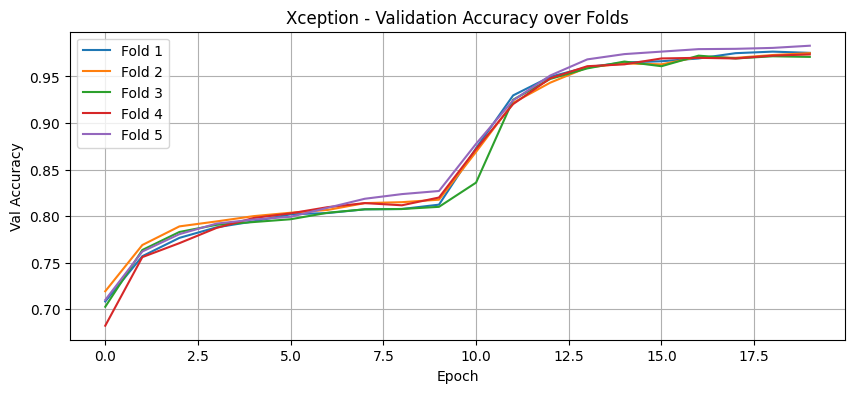

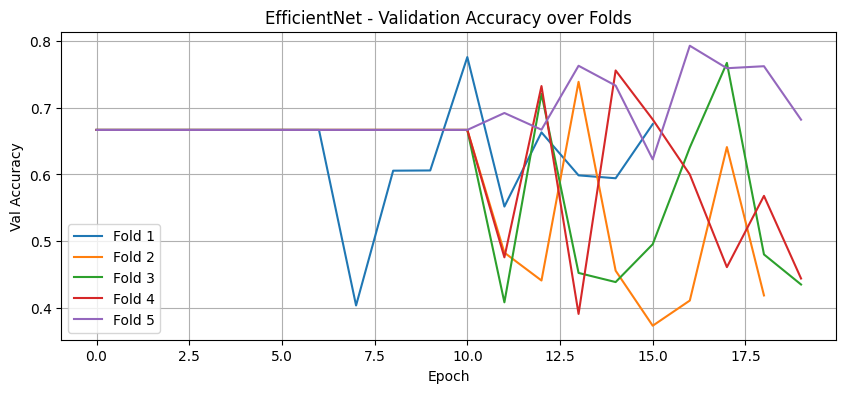

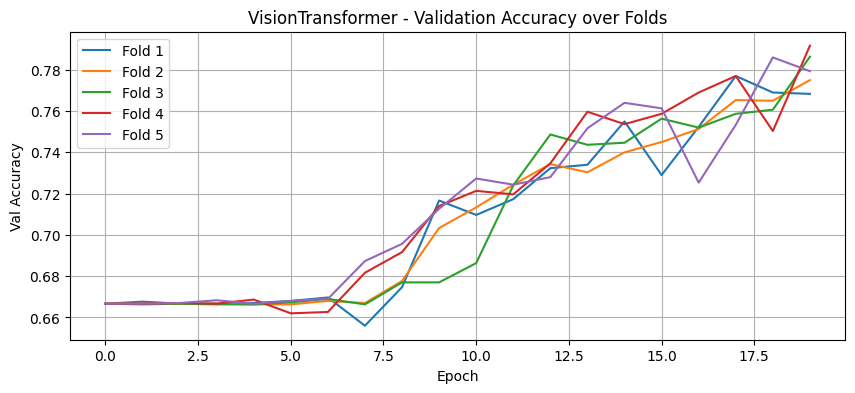

In [ ]:
# === MODEL CONFIGURATION ===
model_configs = {
    'Xception': {'type': 'cnn', 'base': Xception, 'unfreeze_after': 100}, # Fist train with frozen base and unfreeze after 100 layers
    'EfficientNet': {'type': 'cnn', 'base': EfficientNetB0, 'unfreeze_after': 150}, # Fist train with frozen base and unfreeze after 100 layers
    'VisionTransformer': {'type': 'vit'} # Built from cratch
}

# === CROSS-VALIDATION WITH K-FOLD ===
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_results = {}
all_histories = {}

for model_name, config in model_configs.items():
    print(f"\n Training {model_name}")
    fold_scores = []
    model_histories = []
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_all, y_all)): # Split into training and validation data
        print(f"\nFold {fold+1}")
        X_train, X_val = X_all[train_idx], X_all[val_idx]
        y_train, y_val = y_all[train_idx], y_all[val_idx]

# Both CNN models are initialized with pretrained ImageNet weights: Deng et al. (2009). 'ImageNet: A Large-Scale Hierarchical Image Database.' CVPR. https://image-net.org
# The base is frozen during initial training of the classifier head. Fine-tuning is applied by unfreezing top layers after initial convergence.
# Training uses Adam optimizer, early stopping, and model checkpointing for optimal performance.

        if config['type'] == 'cnn':
            base_model = config['base'](weights='imagenet', include_top=False, input_shape=(256, 256, 3)) # pretrained Imagenet weights
            base_model.trainable = False
            model = models.Sequential([
                base_model,
                layers.GlobalAveragePooling2D(),
                layers.Dropout(0.5),
                layers.Dense(1, activation='sigmoid')
            ])

            model.compile(optimizer=optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy']) # Optimizing training
            callbacks = [
                EarlyStopping(patience=5, restore_best_weights=True),
                ModelCheckpoint(f"{model_name}_fold{fold+1}{CHECKPOINT_EXT}", save_best_only=True, monitor='val_loss')
            ]

            print("Training head (base frozen)...")
            history1 = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                                 epochs=10, batch_size=32, callbacks=callbacks, verbose=0)

            base_model.trainable = True
            for layer in base_model.layers[:config['unfreeze_after']]:
                layer.trainable = False

            model.compile(optimizer=optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
            print("Fine-tuning base model...")
            history2 = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                                 epochs=10, batch_size=32, callbacks=callbacks, verbose=0)

            # Combine History
            history = tf.keras.callbacks.History()
            history.history = {k: history1.history.get(k, []) + history2.history.get(k, []) for k in set(history1.history) | set(history2.history)}

            # Print metrics
            final_train_acc = history.history['accuracy'][-1]
            final_val_acc = history.history['val_accuracy'][-1]
            final_train_loss = history.history['loss'][-1]
            final_val_loss = history.history['val_loss'][-1]
            print(f"Fold {fold+1} - Final Train Acc: {final_train_acc:.4f}, Val Acc: {final_val_acc:.4f}")
            print(f"Fold {fold+1} - Final Train Loss: {final_train_loss:.4f}, Val Loss: {final_val_loss:.4f}")

        else:  # Vision Transformer
        # Uses Conv2D for patch extraction, sigmoid activation, applies learned positional embeddings, includes 4 transformer encoder blocks.
            patch_size = 32
            num_patches = (256 // patch_size) ** 2
            projection_dim = 64
            inputs = layers.Input(shape=(256, 256, 3))
            patches = layers.Conv2D(filters=projection_dim, kernel_size=patch_size, strides=patch_size)(inputs)
            patches = layers.Reshape((num_patches, projection_dim))(patches)
            pos_embed = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)(tf.range(num_patches))
            x = patches + pos_embed
            for _ in range(4):
                x1 = layers.LayerNormalization(epsilon=1e-6)(x)
                x1 = layers.MultiHeadAttention(num_heads=4, key_dim=projection_dim//4)(x1, x1)
                x = layers.Add()([x, x1])
                x1 = layers.LayerNormalization(epsilon=1e-6)(x)
                x1 = layers.Dense(projection_dim * 2, activation='gelu')(x1)
                x1 = layers.Dense(projection_dim)(x1)
                x = layers.Add()([x, x1])
            x = layers.LayerNormalization(epsilon=1e-6)(x)
            x = layers.GlobalAveragePooling1D()(x)
            x = layers.Dropout(0.5)(x)
            outputs = layers.Dense(1, activation='sigmoid')(x)
            model = models.Model(inputs, outputs)

            model.compile(optimizer=optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
            callbacks = [
                EarlyStopping(patience=5, restore_best_weights=True),
                ModelCheckpoint(f"{model_name}_fold{fold+1}{CHECKPOINT_EXT}", save_best_only=True, monitor='val_loss')
            ]

            history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                                epochs=20, batch_size=32, callbacks=callbacks, verbose=0)

            # Print metrics
            final_train_acc = history.history['accuracy'][-1]
            final_val_acc = history.history['val_accuracy'][-1]
            final_train_loss = history.history['loss'][-1]
            final_val_loss = history.history['val_loss'][-1]
            print(f"Fold {fold+1} - Final Train Acc: {final_train_acc:.4f}, Val Acc: {final_val_acc:.4f}")
            print(f"Fold {fold+1} - Final Train Loss: {final_train_loss:.4f}, Val Loss: {final_val_loss:.4f}")

        model_histories.append(history)
        scores = model.evaluate(X_val, y_val, verbose=0)
        fold_scores.append(scores[1])

    fold_results[model_name] = fold_scores
    all_histories[model_name] = model_histories

# LEARNING CURVES
print("\n Learning Curves")
for model_name, histories in all_histories.items():
    plt.figure(figsize=(10, 4))
    for i, history in enumerate(histories):
        plt.plot(history.history['val_accuracy'], label=f'Fold {i+1}')
    plt.title(f'{model_name} - Validation Accuracy over Folds')
    plt.xlabel('Epoch')
    plt.ylabel('Val Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
for model, scores in fold_results.items():
    print(f"{model}: {scores}, mean={np.mean(scores):.3f}, std={np.std(scores):.3f}")


Xception: [0.9766666889190674, 0.9750000238418579, 0.9710000157356262, 0.9736666679382324, 0.9829999804496765], mean=0.976, std=0.004
EfficientNet: [0.7756666541099548, 0.7386666536331177, 0.7670000195503235, 0.7556666731834412, 0.7926666736602783], mean=0.766, std=0.018
VisionTransformer: [0.7770000100135803, 0.7749999761581421, 0.7863333225250244, 0.7916666865348816, 0.7860000133514404], mean=0.783, std=0.006


In [ ]:
# EFFECTSIZE
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_std = np.sqrt(((nx - 1) * np.std(x, ddof=1)**2 + (ny - 1) * np.std(y, ddof=1)**2) / (nx + ny - 2))
    return (np.mean(x) - np.mean(y)) / pooled_std

print("\n Effect Size")
for m1 in fold_results:
    for m2 in fold_results:
        if m1 != m2:
            d = cohens_d(fold_results[m1], fold_results[m2])
            print(f"Cohen's d ({m1} vs {m2}): {d:.3f}")

# GAN BIAS PER VAL-SET
print("\n GAN Bias Analyse per Fold (val-set) ")
for model_name, config in model_configs.items():
    print(f"\nModel: {model_name}")
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_all, y_all)):
        print(f"  Fold {fold+1}")
        X_val = X_all[val_idx]
        y_val = y_all[val_idx]
        gan_val = gan_labels[val_idx]

        model_path = f"{model_name}_fold{fold+1}{CHECKPOINT_EXT}"
        model = tf.keras.models.load_model(model_path, compile=False)
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        preds = model.predict(X_val).flatten()
        bin_preds = (preds > 0.5).astype(int)

        df = pd.DataFrame({'true': y_val, 'pred': bin_preds, 'gan': gan_val})
        for gan_type in np.unique(gan_val):
            mask = df['gan'] == gan_type
            if sum(mask) < 5:
                continue
            acc = np.mean(df['true'][mask] == df['pred'][mask])
            print(f"    {gan_type}: acc={acc:.2f}")



 Effect Size
Cohen's d (Xception vs EfficientNet): 14.234
Cohen's d (Xception vs VisionTransformer): 32.812
Cohen's d (EfficientNet vs Xception): -14.234
Cohen's d (EfficientNet vs VisionTransformer): -1.134
Cohen's d (VisionTransformer vs Xception): -32.812
Cohen's d (VisionTransformer vs EfficientNet): 1.134

 GAN Bias Analyse per Fold (val-set) 

Model: Xception
  Fold 1
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step
    ATTGAN: acc=0.98
    GDWCT: acc=0.96
    REAL: acc=0.98
    STYLEGAN: acc=0.95
    STYLEGAN2: acc=0.96
    StarGAN: acc=1.00
  Fold 2
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step
    ATTGAN: acc=0.98
    GDWCT: acc=0.95
    REAL: acc=0.98
    STYLEGAN: acc=0.94
    STYLEGAN2: acc=0.95
    StarGAN: acc=0.98
  Fold 3
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step
    ATTGAN: acc=0.98
    GDWCT: acc=0.97
    REAL: acc=0.98
    STYLEGAN: acc=0.91
    STYLEGAN2: acc=0.89
    StarGAN: acc=1.00
  Fold 4
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step
    ATTGAN: acc=0.99
    GDWCT: acc=0.93
    REA


 Testset Evaluatie
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step

Xception
              precision    recall  f1-score   support

        Real       0.43      0.94      0.59      2000
        Fake       0.95      0.51      0.66      5000

    accuracy                           0.63      7000
   macro avg       0.69      0.72      0.63      7000
weighted avg       0.80      0.63      0.64      7000



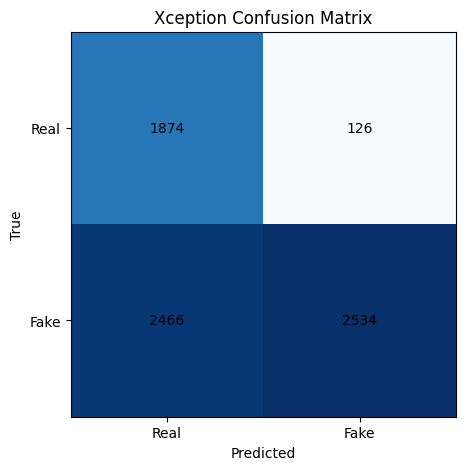

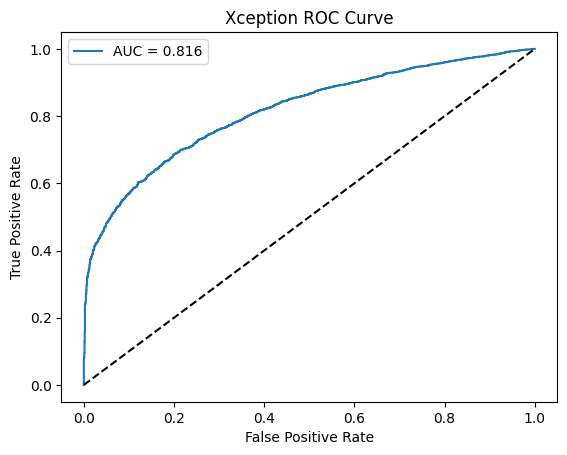

219/219 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step

EfficientNet
              precision    recall  f1-score   support

        Real       0.40      0.72      0.51      2000
        Fake       0.83      0.57      0.68      5000

    accuracy                           0.61      7000
   macro avg       0.62      0.64      0.59      7000
weighted avg       0.71      0.61      0.63      7000



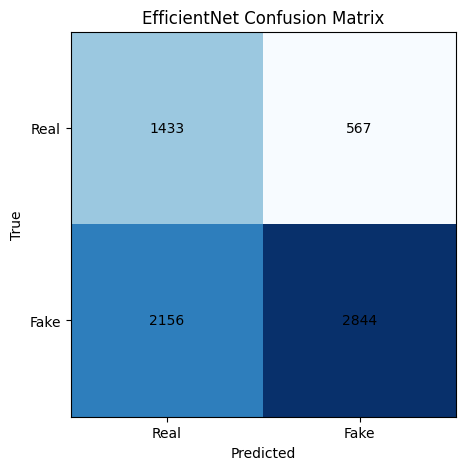

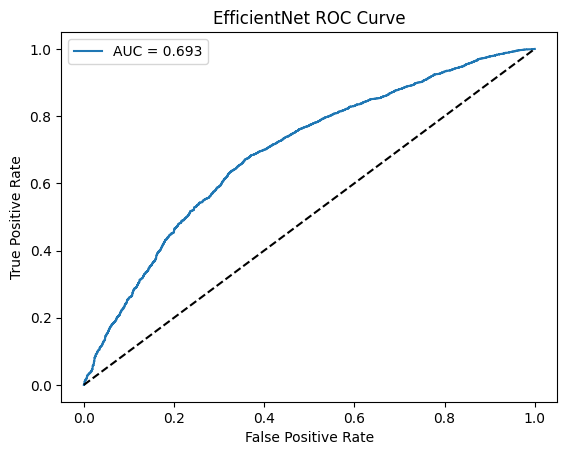

219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step

VisionTransformer
              precision    recall  f1-score   support

        Real       0.36      0.92      0.52      2000
        Fake       0.92      0.35      0.51      5000

    accuracy                           0.52      7000
   macro avg       0.64      0.64      0.52      7000
weighted avg       0.76      0.52      0.51      7000



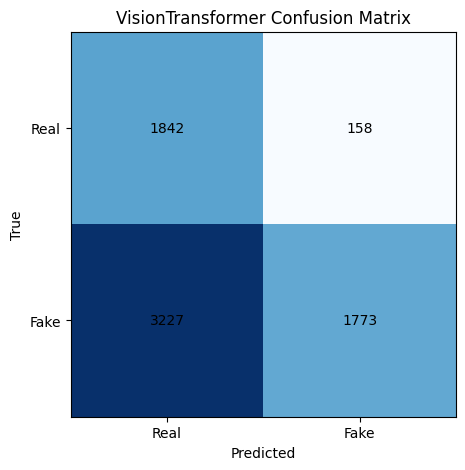

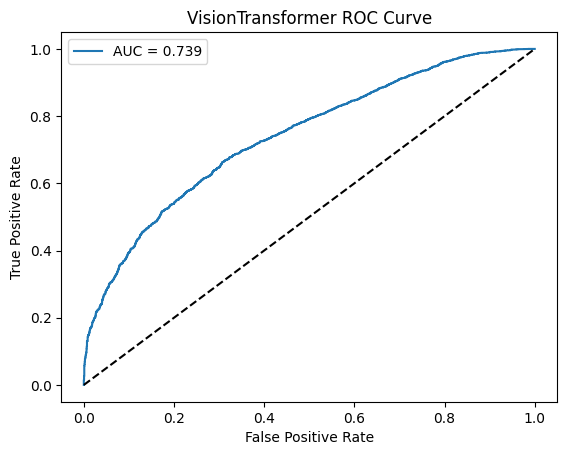


 Results
                   accuracy  precision  recall        f1       auc
Xception           0.629714   0.952632  0.5068  0.661619  0.815803
EfficientNet       0.611000   0.833773  0.5688  0.676257  0.693028
VisionTransformer  0.516429   0.918177  0.3546  0.511614  0.739470

Resultaten opgeslagen als model_comparison_results.csv


In [ ]:
## TESTSET EVALUATIE
print("\n Testset Evaluatie")
final_results = {}
for model_name in fold_results:
    model_path = f"{model_name}_fold1{CHECKPOINT_EXT}"
    model = tf.keras.models.load_model(model_path, compile=False)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    y_pred = model.predict(X_test).flatten()
    y_pred_bin = (y_pred > 0.5).astype(int)
    final_results[model_name] = {
        'accuracy': np.mean(y_pred_bin == y_test),
        'precision': precision_score(y_test, y_pred_bin),
        'recall': recall_score(y_test, y_pred_bin),
        'f1': f1_score(y_test, y_pred_bin),
        'auc': roc_auc_score(y_test, y_pred)
    }

    print(f"\n{model_name}")
    print(classification_report(y_test, y_pred_bin, target_names=['Real', 'Fake']))

    cm = confusion_matrix(y_test, y_pred_bin)
    plt.figure(figsize=(5,5))
    plt.imshow(cm, cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks([0,1], ['Real', 'Fake'])
    plt.yticks([0,1], ['Real', 'Fake'])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(cm[i][j]), ha='center', va='center')
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {final_results[model_name]["auc"]:.3f}')
    plt.plot([0,1], [0,1], 'k--')
    plt.title(f'{model_name} ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

# Results
print("\n Results")
results_df = pd.DataFrame(final_results).T
print(results_df)
results_df.to_csv("model_comparison_results.csv")
print("\nResultaten opgeslagen als model_comparison_results.csv")


Top 3 confident misclassifications for Xception:
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step


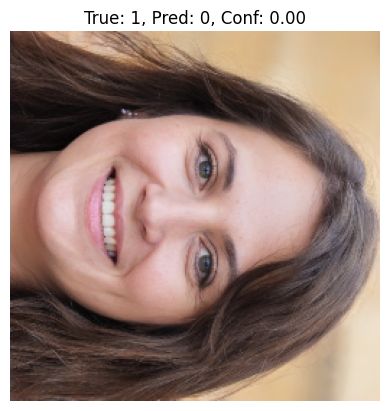

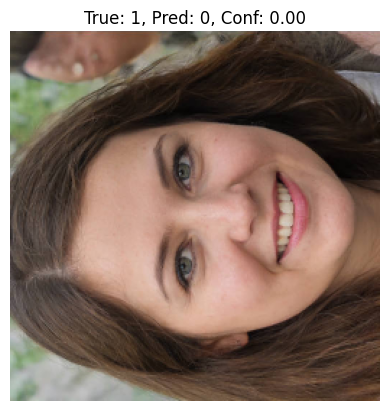

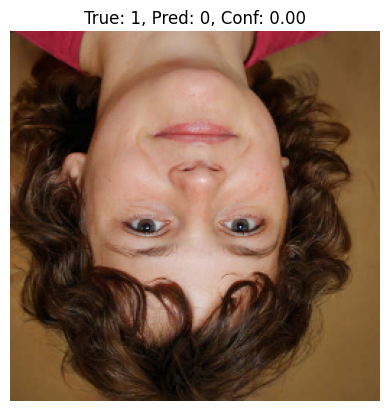


Top 3 confident misclassifications for EfficientNet:
219/219 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step


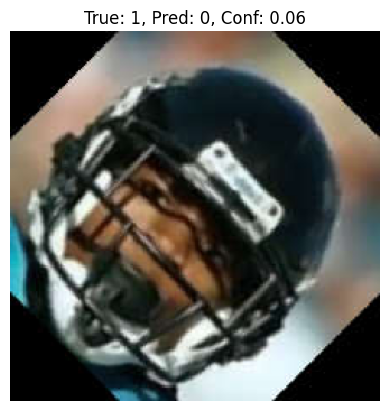

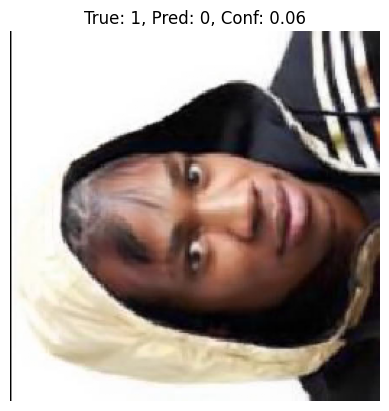

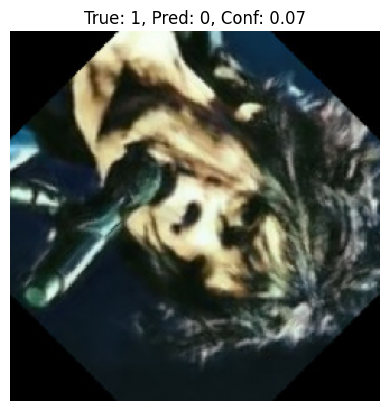


Top 3 confident misclassifications for VisionTransformer:
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


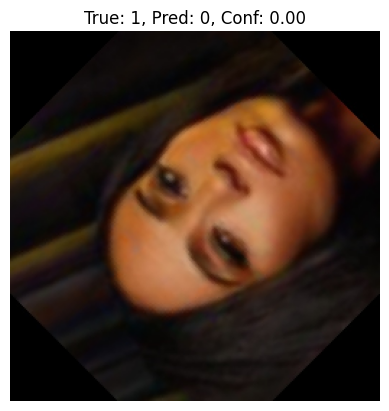

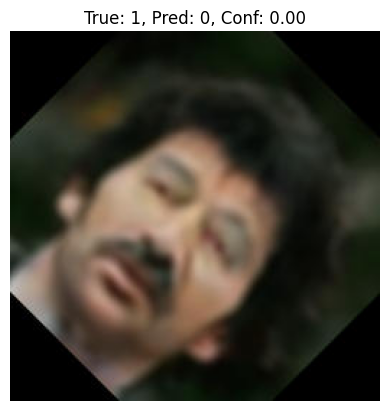

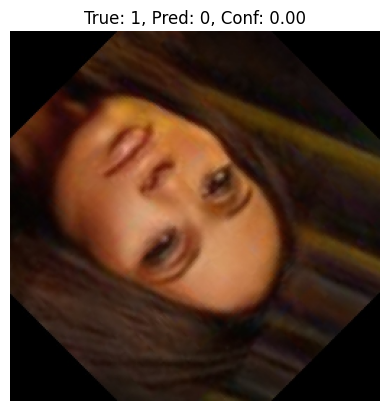

In [ ]:
# Top 3 confident misclassifications
for model_name in fold_results:
    print(f"\nTop 3 confident misclassifications for {model_name}:")

    model_path = f"{model_name}_fold1{CHECKPOINT_EXT}"
    model = tf.keras.models.load_model(model_path, compile=False)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    y_pred = model.predict(X_test).flatten()
    y_pred_bin = (y_pred > 0.5).astype(int)
    confidences = np.abs(y_pred - 0.5)

    errors = (y_pred_bin != y_test)
    error_indices = np.where(errors)[0]
    confident_errors = error_indices[np.argsort(-confidences[error_indices])[:3]]

    for idx in confident_errors:
        plt.imshow(X_test[idx])
        plt.title(f"True: {y_test[idx]}, Pred: {y_pred_bin[idx]}, Conf: {y_pred[idx]:.2f}")
        plt.axis('off')
        plt.show()





=== Saliency Maps for Top 3 Confident Errors ===

Xception - Saliency Maps
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step


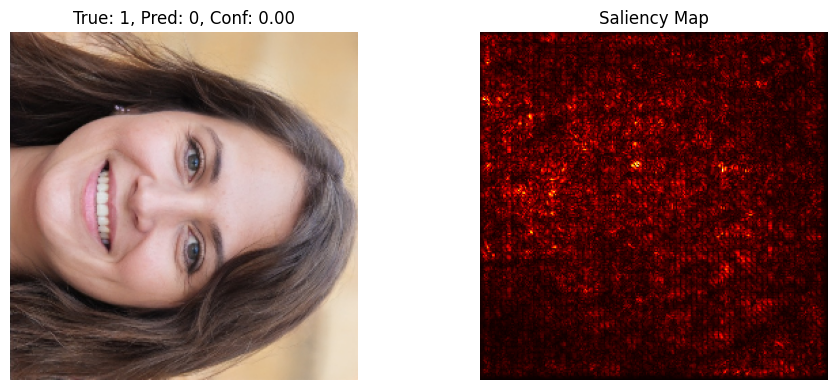

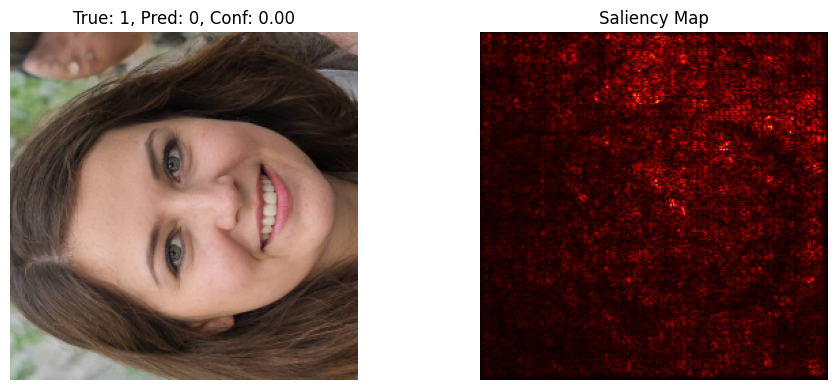

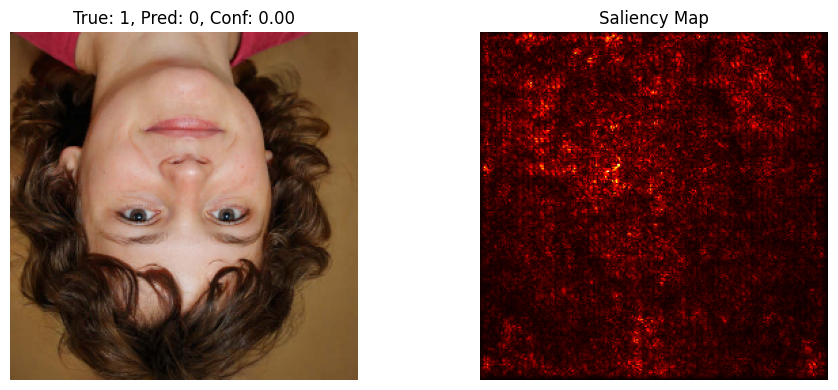


EfficientNet - Saliency Maps
219/219 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step


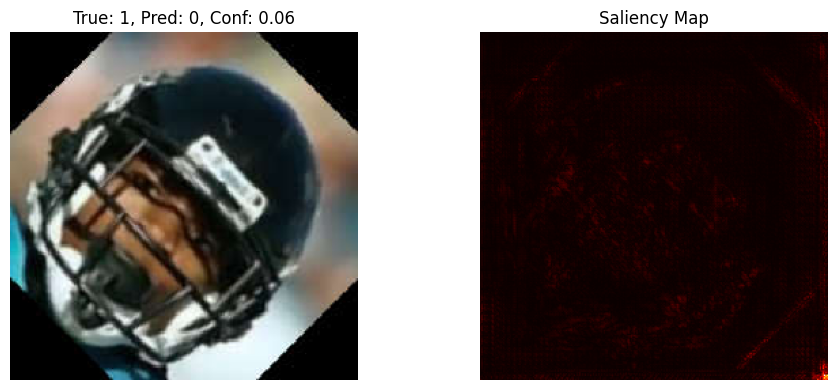

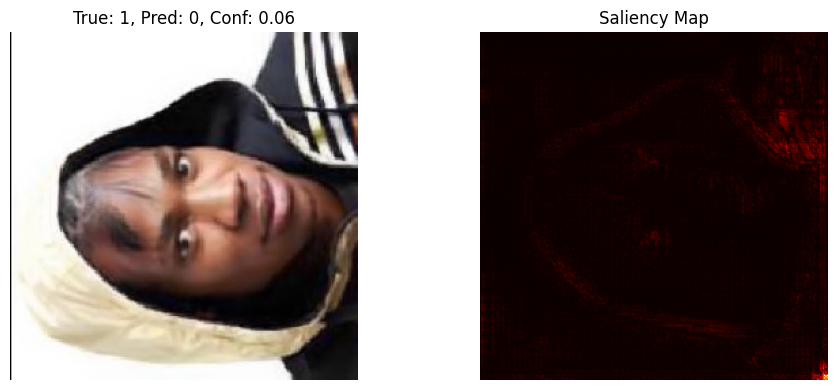

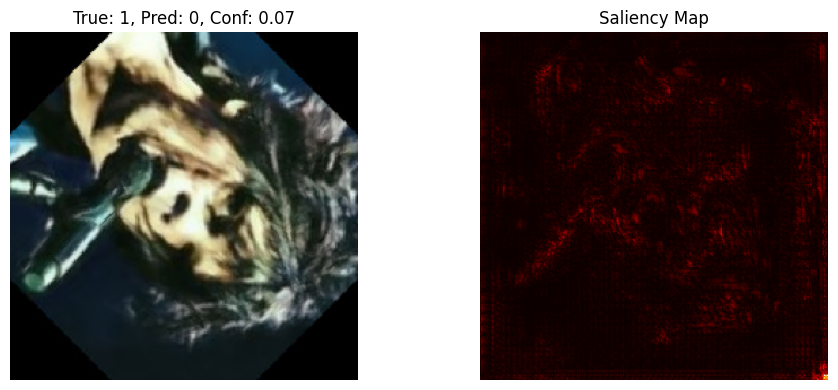


VisionTransformer - Saliency Maps
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


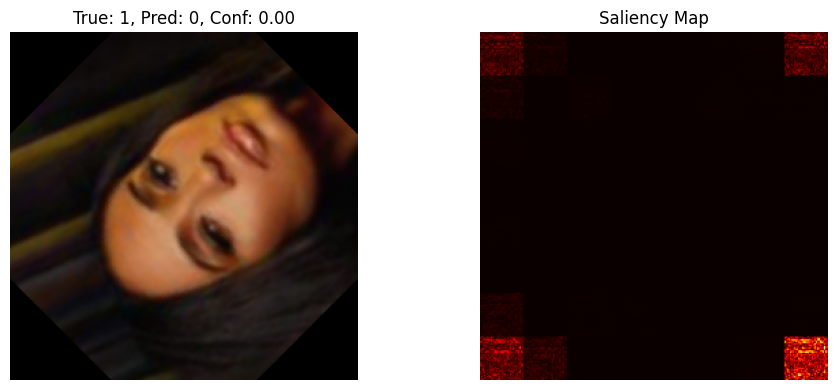

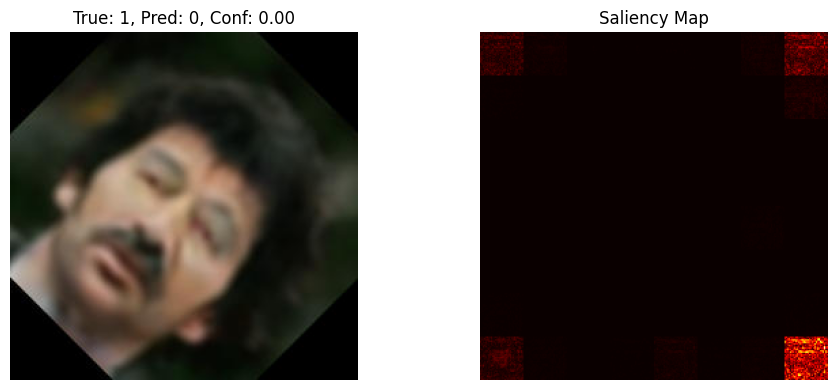

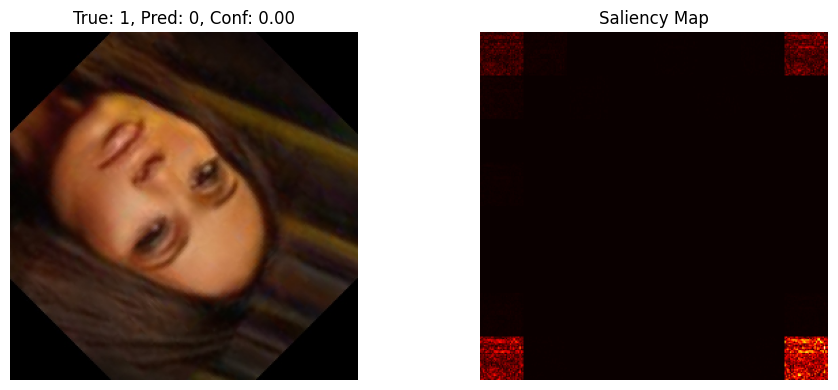

In [ ]:
# SALIENCY MAPS FOR MISCLASSIFICATIONS
print("\n Saliency Maps for Top 3 Confident Errors ")
for model_name in fold_results:
    print(f"\n{model_name} - Saliency Maps")

    model_path = f"{model_name}_fold1{CHECKPOINT_EXT}"
    model = tf.keras.models.load_model(model_path, compile=False)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    y_pred = model.predict(X_test).flatten()
    y_pred_bin = (y_pred > 0.5).astype(int)
    confidences = np.abs(y_pred - 0.5)

    errors = (y_pred_bin != y_test)
    error_indices = np.where(errors)[0]
    confident_errors = error_indices[np.argsort(-confidences[error_indices])[:3]]

    for idx in confident_errors:
        img = X_test[idx]
        input_img = tf.convert_to_tensor(img[np.newaxis, ...])

        with tf.GradientTape() as tape:
            tape.watch(input_img)
            prediction = model(input_img)
            loss = prediction[0][0]  # scalar output

        grads = tape.gradient(loss, input_img)[0]  # shape: (256, 256, 3)
        saliency = tf.reduce_max(tf.abs(grads), axis=-1)  # shape: (256, 256)

        plt.figure(figsize=(10, 4))

        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title(f"True: {y_test[idx]}, Pred: {y_pred_bin[idx]}, Conf: {y_pred[idx]:.2f}")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(saliency, cmap='hot')
        plt.title("Saliency Map")
        plt.axis('off')

        plt.tight_layout()
        plt.show()
